In [1]:
import numpy as np
import pandas as pd
import pickle


from matplotlib import pyplot as plt
%matplotlib inline 

from utils.train_conformal import train_conformal_forecaster

## Data processing

Energy data
* Predicting the `Appliances` variable
* Splitting the sequence with $T=60$ (10 hours) and $H=12$ (2 hours)

Stock data
* Predicting the `Close` price of ?? stock
* Splitting at higher granularity: $T=30$ and $H=10$ (month and 10 days)

Hungarian chickenpox data
* Predicting the weekly number of cases
* Train on most regions and choose other regions for testing (this can fail because different regions can follow different distributions)
* Choose $T=8$, $H=4$ (given past two months, what is the forecast for the next month)

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
from utils.uci_data_processing import prepare_uci_datasets

In [9]:
prepare_uci_datasets()

Dataset: energy, calibrated: True
Dataset: energy, calibrated: False
Dataset: stock, calibrated: True
Dataset: stock, calibrated: False
Dataset: hungary, calibrated: True
Dataset: hungary, calibrated: False


In [66]:
def plot_ts(dataset, coverages, intervals, idx=None, forecast_only=False):
    fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12, 8), sharex=True)
    
    if idx is None:
        idx = range(len(dataset))

    for ax in axs.flat:
        i = np.random.choice(idx)
        
        # Derive unpadded sequences and targets
        sequence, target, length = dataset[i]
        
        horizon = min(len(target), length)
        sequence, target = sequence[:length].flatten().tolist(), target[:horizon].flatten().tolist()
        
        if not forecast_only:
            # (Scatter)plot of the time series
            ax.plot(range(1, length+1), sequence, color="black")
            
            # Prediction start vertical
            ax.axvline(length, linestyle="--", color="black")
        
        ax.scatter(range(length + 1, length + horizon + 1), target, color="black")
        
        # Interval boundaries
        lower = [sequence[-1]] + intervals[i, 0].flatten().tolist()[:horizon]
        upper = [sequence[-1]] + intervals[i, 1].flatten().tolist()[:horizon]
        pred = [sequence[-1]] + (intervals[i, 0] + (intervals[i, 1] - intervals[i, 0]) / 2).flatten().tolist()[:horizon]
        
        ax.fill_between(range(length, length + horizon + 1), lower, upper, color="r", alpha=0.25)
        ax.plot(range(length, length + horizon + 1), lower, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), upper, linestyle="--", color="r")
        ax.plot(range(length, length + horizon + 1), pred, linestyle="--", linewidth=3, color="r")

        ax.set(ylabel='Prediction')
    
    plt.xlabel('Time step')
    #     plt.ylabel('Prediction')
    plt.show()

In [95]:
with open('data/stock_calibrated_default_test.pkl', 'rb') as f:
    test_dataset = pickle.load(f)
stock_results = baselines['CoRNN']['stock']

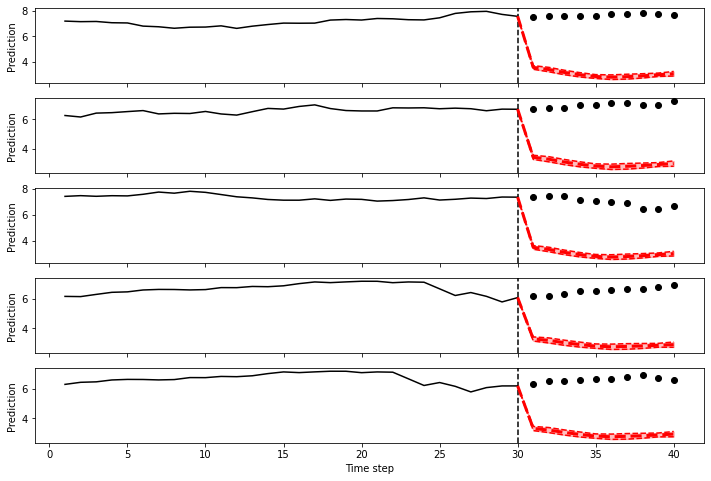

In [96]:
plot_ts(test_dataset, stock_results['coverages'], stock_results['intervals'])

In [17]:
from utils.uci_data_processing import run_uci_experiments
baselines = run_uci_experiments(baselines=['QRNN', 'DPRNN'], retrain=True)

QRNN, energy
Epoch:  0 | train loss: 0.4792
Epoch:  0 | train loss: 0.1978
Epoch:  0 | train loss: 0.1704
Epoch:  0 | train loss: 0.2196
Epoch:  0 | train loss: 0.1953
Epoch:  0 | train loss: 0.1864
Epoch:  0 | train loss: 0.1425
Epoch:  0 | train loss: 0.1838
Epoch:  0 | train loss: 0.1951
Epoch:  0 | train loss: 0.1824
Epoch:  1 | train loss: 0.1911
Epoch:  1 | train loss: 0.1539
Epoch:  1 | train loss: 0.1392
Epoch:  1 | train loss: 0.1810
Epoch:  1 | train loss: 0.1131
Epoch:  1 | train loss: 0.1567
Epoch:  1 | train loss: 0.2113
Epoch:  1 | train loss: 0.1564
Epoch:  1 | train loss: 0.1412
Epoch:  1 | train loss: 0.1429
Epoch:  2 | train loss: 0.1540
Epoch:  2 | train loss: 0.1228
Epoch:  2 | train loss: 0.1545
Epoch:  2 | train loss: 0.1430
Epoch:  2 | train loss: 0.1550
Epoch:  2 | train loss: 0.1426
Epoch:  2 | train loss: 0.1357
Epoch:  2 | train loss: 0.1253
Epoch:  2 | train loss: 0.1589
Epoch:  2 | train loss: 0.1232
Epoch:  3 | train loss: 0.1468
Epoch:  3 | train loss: 0.

In [25]:
baselines = run_uci_experiments(baselines=['CoRNN'], retrain=True)

CoRNN, energy
Epoch: 0	Train loss: 0.8697029607636588
Epoch: 50	Train loss: 0.6368449819939477
CoRNN, stock
Epoch: 0	Train loss: 0.37644054353810275
Epoch: 50	Train loss: 0.009363923275556702
Epoch: 100	Train loss: 0.009251735370176343
Epoch: 150	Train loss: 0.009572926729630966
Epoch: 200	Train loss: 0.008958990990112606
Epoch: 250	Train loss: 0.008904882867892202
Epoch: 300	Train loss: 0.008268369039377341
Epoch: 350	Train loss: 0.007123317014282713
Epoch: 400	Train loss: 0.006455318250048619
Epoch: 450	Train loss: 0.005237145027002463
Epoch: 500	Train loss: 0.005412258315258301
Epoch: 550	Train loss: 0.004580313035358603
Epoch: 600	Train loss: 0.0037649451898267637
Epoch: 650	Train loss: 0.004002160321061428
Epoch: 700	Train loss: 0.004093537913062251
Epoch: 750	Train loss: 0.003024599040285326
Epoch: 800	Train loss: 0.004942499047431808
Epoch: 850	Train loss: 0.002913092585423818
Epoch: 900	Train loss: 0.002873100882145361
Epoch: 950	Train loss: 0.0026468559920501252
CoRNN, hungary

In [30]:
baselines['CoRNN']['hungary']['mean_coverage']

0.9367647171020508

In [29]:
baselines = run_uci_experiments(retrain=False)

CoRNN, energy
QRNN, energy
DPRNN, energy
CoRNN, stock
QRNN, stock
DPRNN, stock
CoRNN, hungary
QRNN, hungary
DPRNN, hungary


In [46]:
for dataset in ['energy', 'stock', 'hungary']:
    print(baselines['QRNN'][dataset]['Coverage'])

0.9118421052631579
0.11094224924012158
0.8947303921568628


In [44]:
for dataset in ['energy', 'stock', 'hungary']:
    widths = baselines['CoRNN'][dataset]['interval_widths']
    print(np.mean(widths), np.std(widths))

7.185693383216858 0.7295036651261846
5.473923110961914 0.1700629499425274
3.1405014991760254 0.166563035124521


In [49]:
ci = baselines['QRNN']['energy']['Confidence intervals']

In [50]:
len(ci)

380

In [53]:
np.mean(ci[1])

0.91411614

In [62]:
for dataset in ['energy', 'stock', 'hungary']:
    ci = baselines['QRNN'][dataset]['Confidence intervals']
    ci_mean = np.mean([np.mean(c) for c in ci])
    ci_std = np.mean([np.std(c) for c in ci])
    print('{:.2f} \\(\\pm\\) {:.2f}'.format(ci_mean, ci_std))

1.76 \(\pm\) 0.46
0.29 \(\pm\) 0.09
1.51 \(\pm\) 0.18


In [71]:
baselines = run_uci_experiments(baselines=['CoRNN'], datasets=['stock'], retrain=True)


CoRNN, stock
Epoch: 0	Train loss: 0.4230421669781208
Epoch: 50	Train loss: 0.009497724885407548
Epoch: 100	Train loss: 0.009157068722953018
Epoch: 150	Train loss: 0.00893707385358329
Epoch: 200	Train loss: 0.008018833047782
Epoch: 250	Train loss: 0.007477487365786846
Epoch: 300	Train loss: 0.006853185701542175
Epoch: 350	Train loss: 0.006226424521838243
Epoch: 400	Train loss: 0.004790516453795135
Epoch: 450	Train loss: 0.0034170312574133277
Epoch: 500	Train loss: 0.0025764880925775147
Epoch: 550	Train loss: 0.0020536567720298013
Epoch: 600	Train loss: 0.002429847520453712
Epoch: 650	Train loss: 0.0023467616993002594
Epoch: 700	Train loss: 0.0017645572079345584
Epoch: 750	Train loss: 0.0017200388650123316
Epoch: 800	Train loss: 0.0017264922050974118
Epoch: 850	Train loss: 0.0012666551808181864
Epoch: 900	Train loss: 0.0011807881304636025
Epoch: 950	Train loss: 0.0011076139187655197


In [84]:
stock_results = baselines['CoRNN']['stock']

In [76]:
from utils.uci_data_processing import prepare_uci_datasets
prepare_uci_datasets(datasets=['stock'], calibrates=[True], suffix='higher_train')

Dataset: stock, calibrated: True


In [83]:
from utils.uci_data_processing import run_uci_experiments
baselines = run_uci_experiments(datasets=['stock'], baselines=['CoRNN'], suffix='higher_train', retrain=True)

CoRNN, stock
Epoch: 0	Train loss: 0.27546990625560286
Epoch: 50	Train loss: 0.007631435695414742
Epoch: 100	Train loss: 0.007075917456919948
Epoch: 150	Train loss: 0.007194480827699105
Epoch: 200	Train loss: 0.007718435713710884
Epoch: 250	Train loss: 0.006590768710399667
Epoch: 300	Train loss: 0.006112052158763011
Epoch: 350	Train loss: 0.006471277688009044
Epoch: 400	Train loss: 0.006155254319310188
Epoch: 450	Train loss: 0.00546047060439984
Epoch: 500	Train loss: 0.0056181696631635225
Epoch: 550	Train loss: 0.003685185293822239
Epoch: 600	Train loss: 0.0044833012313271565
Epoch: 650	Train loss: 0.004892234403329591
Epoch: 700	Train loss: 0.0035428591383000214
Epoch: 750	Train loss: 0.0047069001942873
Epoch: 800	Train loss: 0.004249232425354421
Epoch: 850	Train loss: 0.004152367279554407
Epoch: 900	Train loss: 0.0037406862635786333
Epoch: 950	Train loss: 0.0035796935747688017


In [93]:
for dataset in ['energy', 'stock', 'hungary']:
    with open('data/{}_calibrated_default_train.pkl'.format(dataset), 'rb') as f:
        d = pickle.load(f)
        n_train = len(d)
    with open('data/{}_calibrated_default_calibrate.pkl'.format(dataset), 'rb') as f:
        d = pickle.load(f)
        n_calibrate = len(d)
    print(n_train, n_calibrate, n_train+n_calibrate)

2748 775 3523
2539 697 3236
5610 2550 8160


In [92]:
for dataset in ['energy', 'stock', 'hungary']:
    with open('data/{}_raw_default_train.pkl'.format(dataset), 'rb') as f:
        d = pickle.load(f)
        n_train = len(d[0])
    print(n_train)

3537
3276
8160


In [98]:
df = pd.read_csv('data/stock_data.csv')
train_features = ['Close']

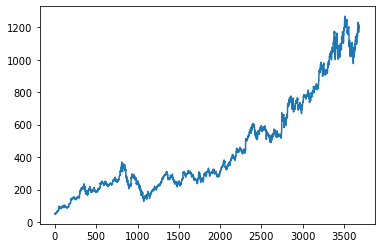

In [99]:
plt.plot(df['Close'])

In [100]:
df

,Open,High,Low,Close,Adj_Close,Volume
0,49.676899,51.693783,47.669952,49.845802,49.845802,44994500
1,50.178635,54.187561,49.925285,53.805050,53.805050,23005800
2,55.017166,56.373344,54.172661,54.346527,54.346527,18393200
3,55.260582,55.439419,51.450363,52.096165,52.096165,15361800
4,52.140873,53.651051,51.604362,52.657513,52.657513,9257400
...,...,...,...,...,...,...
3680,1207.479980,1216.300049,1200.500000,1205.920044,1205.920044,1017800
3681,1205.939941,1215.670044,1204.130005,1215.000000,1215.000000,950000
3682,1214.989990,1216.219971,1205.030029,1207.150024,1207.150024,907200
3683,1207.890015,1208.689941,1199.859985,1203.839966,1203.839966,860200


In [101]:
df = pd.read_csv('data/energy_data.csv')
df

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,60,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
1,60,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2,50,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
3,50,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
4,60,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19730,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.700000,45.790000,...,23.200000,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784


In [103]:
df = pd.read_csv('data/hungary_chickenpox/hungary_chickenpox.csv')
df

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,01/12/2014,95,12,41,6,39,0,16,15,14,...,56,7,13,122,4,23,4,11,110,10
518,08/12/2014,43,39,31,10,34,3,2,30,25,...,34,20,18,70,36,5,23,22,63,9
519,15/12/2014,35,7,15,0,0,0,7,7,4,...,30,36,4,72,5,21,14,0,17,10
520,22/12/2014,30,23,8,0,11,4,1,9,10,...,27,17,21,12,5,17,1,1,83,2
